In [ ]:
%%shell
rm *.csv*
wget -nv https://storage.googleapis.com/cse144/{train,test}.csv

2022-02-14 07:19:59 URL:https://storage.googleapis.com/cse144/train.csv [32902/32902] -> "train.csv" [1]
2022-02-14 07:19:59 URL:https://storage.googleapis.com/cse144/test.csv [8270/8270] -> "test.csv" [1]
FINISHED --2022-02-14 07:19:59--
Total wall clock time: 0.02s
Downloaded: 2 files, 40K in 0s (117 MB/s)


In [ ]:
!pip install -Uqq ipdb
import ipdb

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format="retina"
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



def plot_data(x: np.ndarray, y: np.ndarray) -> None:
    """
    Plot a dataset with 2-d feature vectors and binary labels. 

    Args:
        x: 2-d feature vectors
        y: 1-d binary labels.
    """
    class0_idx = np.where(y == 0)[0]
    class1_idx = np.where(y == 1)[0]
    feature0 = x[:, 0]
    feature1 = x[:, 1]
    plt.scatter(feature0[class0_idx], feature1[class0_idx], label="0")
    plt.scatter(feature0[class1_idx], feature1[class1_idx], label="1")
    plt.legend()
    plt.show()


def plot_decision_boundary(theta, x) -> None:
    """
    Plot the decision boundary using theta. Use this function with plot_data().

    Args:
        theta: a 3-d weight vector.
        x: 2-d feature vectors, which is used to decide the span of the decision
           boundary.
    """
    xx = np.linspace(min(x[:, 0]), max(x[:, 0]))
    yy = (-theta[1] / theta[2]) * xx - (theta[0]) / theta[2]
    #yy = (-theta[0] / theta[1]) * xx - (theta[0]) / theta[1]
    plt.plot(xx, yy, color="red", label="boundary")
    plt.ylim(min(x[:, 1]), max(x[:, 1]))


# Read datasts and split your training data into train & validation sets. Split
# features from labels after that.

train_set = pd.read_csv('train.csv').dropna();

test_set = pd.read_csv('test.csv').dropna();


train_y_data = train_set['label'].copy()

train_x_data = train_set.drop(columns = 'label')


test_y_data = test_set['label'].copy()

test_x_data = test_set.drop(columns = 'label')


y_test = test_y_data.to_numpy()

x_test = test_x_data.to_numpy()



val_size = .2

seed = 420


x_train , x_val , y_train , y_val = train_test_split(train_x_data,train_y_data, test_size = val_size , random_state = seed , shuffle = True)


y_train = y_train.to_numpy()

x_train = x_train.to_numpy()

y_val = y_val.to_numpy()

x_val = x_val.to_numpy()



print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(640, 2) (640,)
(160, 2) (160,)
(200, 2) (200,)


## Plot training and validation sets

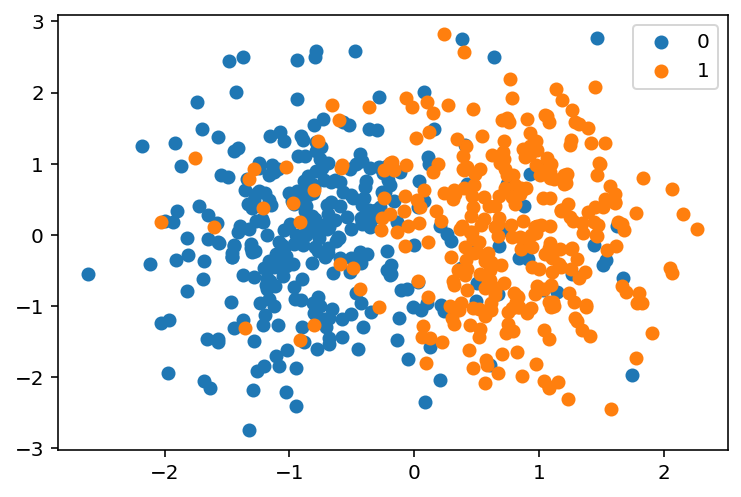

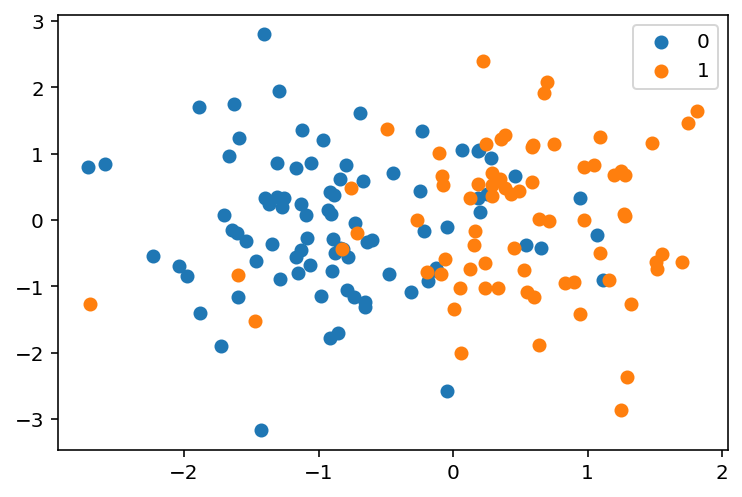

In [ ]:
plot_data(x_train, y_train)
plot_data(x_val, y_val)

In [ ]:
#Prepend 1's 
num_samples = x_train.shape[0]
np.ones(num_samples)
my_ones = np.ones(num_samples)
x_train = np.c_[my_ones,x_train]

num_samples = x_val.shape[0]
np.ones(num_samples)
my_ones = np.ones(num_samples)
x_val = np.c_[my_ones,x_val]

num_samples = x_test.shape[0]
np.ones(num_samples)
my_ones = np.ones(num_samples)
x_test = np.c_[my_ones,x_test]

In [ ]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(640, 3) (640,)
(160, 3) (160,)
(200, 3) (200,)


In [ ]:
class LogisticRegressionTrainer:
    def __init__(
        self,
        num_features: int,
        learning_rate: float = 1e-2,
        num_epochs: int = 500,
        lambd: float = 0.0,
    ) -> None:
        """Initialize a logisitc regression trainer."""
        self.lambd = lambd
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.num_features = num_features
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.test_loss = None
        self.test_acc = None

        # Initialize weights (parameters) for your model. You can use any initialization methods.

        self.theta = np.zeros(num_features+1)


    def gradient_descent_step(self, x: np.ndarray, y: np.ndarray) -> None:
        """
        Perform a single step of gradient update.

        Args:
            x: A matrix of features.
            y: A vector of labels.
        """


        self.theta = self.theta - (self.learning_rate)*self.cross_entropy_loss_derivative(x,y)


    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """
        Convert raw model output (logits) to probabilities.

        Args:
            z: Raw model output (logits).

        Returns:
            A vector (or float, if your input is a scalar) of probabilties.
        """

        return 1 / (1 + np.exp(-z))


    def cross_entropy_loss(self, pred: np.ndarray, target: np.ndarray) -> float:
        """
        Calculates the binary cross-entropy loss given predictions and targets.
        The loss function should add the regularization term.

        Args:
            pred: Predicted labels (probabilities).
            target: Ground-truth labels.

        Returns:
            A scalar of loss.
        """
        assert pred.shape == target.shape

        N = pred.size 

        loss = 0 

        for i in range(N):

          loss += target[i]*np.log(pred[i]) + (1 - target[i])*np.log(1 - pred[i])

        aggregate_loss_unbiased = (-1 / N)*loss  

        bias = self.lambd*np.sum(np.square(self.theta))

        return aggregate_loss_unbiased + bias

    def cross_entropy_loss_derivative(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Calculate the derivative of the loss function w.r.t. theta. The derivative of the
        loss function should also add the derivative of the L2 regularization term.

        Args:
            x: Feature vectors.
            y: Ground-truth labels.

        Returns:
            A vector with the same dimension as theta, where each element is the
            partial derivative of the loss function w.r.t. the corresponding element
            in theta.
        """

        # val = np.zeros(2)

        # pred = self.sigmoid(np.dot(self.theta,x.T))

        # breakpoint()
        
        # for N in range(y.size):

        #   val += pred[N]*(1 - pred[N])*(y[N] / pred[N] - (1 - y[N]) / (1 - pred[N]))
          
        # return val


        LD = np.dot(x,self.theta) - y

        return self.sigmoid(np.dot(x.T,LD)) + self.lambd*2*np.sum(np.square(self.theta))


    def accuracy(self, pred: np.ndarray, target: np.ndarray) -> float:
        """
        Calculates the percentage of matched labels given predictions and targets.

        Args:
            pred: Predicted labels (rounded probabilities).
            target: Ground-truth labels.

        Return:
            The accuracy score (a float) given the predicted labels and the true labels.
        """
        assert pred.shape == target.shape

        num_wrong = np.sum(abs(target - pred))

        length = target.size 

        acc = (length - num_wrong)/length

        return acc

    def train(
        self,
        x_train: np.ndarray,
        y_train: np.ndarray,
        x_val: np.ndarray,
        y_val: np.ndarray,
    ) -> None:
        """
        Run gradient descent for n epochs, where n = self.num_epochs. In every epoch,
            1. Update theta.
            2. Calculate the training loss & accuracy given the current theta, and append 
               then to self.train_loss_history and self.train_acc_history.
            3. Calculate the validation loss & accuracy given the current theta, and 
               append then to self.train_loss_history and self.train_acc_history.

        If you wish to use the bias trick, please remember to use it before the for loop.

        Args:
            x_train: Feature vectors for training.
            y_train: Ground-truth labels for training.
            x_val: Feature vectors for validation.
            y_val: Ground-truth labels for validation.
        """

        for n in range(self.num_epochs):

          #input()

          #self.gradient_descent_step(x_train,y_train)
          #print(self.sigmoid(np.dot(x_train,self.theta)))
          #print(y_train)
          #input()
          self.train_loss_history.append(self.cross_entropy_loss(self.sigmoid(np.dot(x_train,self.theta)),y_train))

          self.train_acc_history.append(self.accuracy(np.round(self.sigmoid(np.dot(x_train,self.theta))),y_train))


          self.val_loss_history.append(self.cross_entropy_loss(self.sigmoid(np.dot(x_val,self.theta)),y_val))

          self.val_acc_history.append(self.accuracy(np.round(self.sigmoid(np.dot(x_val,self.theta))),y_val))


          self.gradient_descent_step(x_train,y_train)


    def evaluate(self, x_test: np.ndarray, y_test: np.ndarray) -> None:
        """
        Evaluate the model on test set and store the test loss int self.test_loss and 
        test accuracy in self.test_acc. In other words, you should get the test loss and accraucy here.

        If you used the bias trick in train(), you have to also use it here.

        Args:
            x_test: Feature vectors for testing.
            y_test: Ground-truth labels for testing.
        """

        self.test_loss = self.cross_entropy_loss(self.sigmoid(np.dot(x_test,self.theta)),y_test)

        self.test_acc = self.accuracy(np.round(self.sigmoid(np.dot(x_test,self.theta))),y_test)


In [ ]:
%xmode Verbose

Exception reporting mode: Verbose


Final train loss: 0.6931471969212107
Final validation loss: 0.6931471939943604
Final train acc: 0.48125
Final validation acc: 0.48125


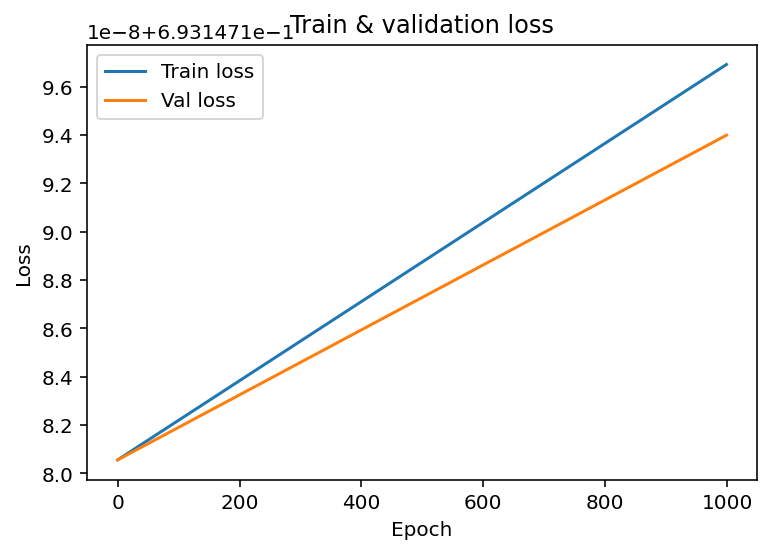

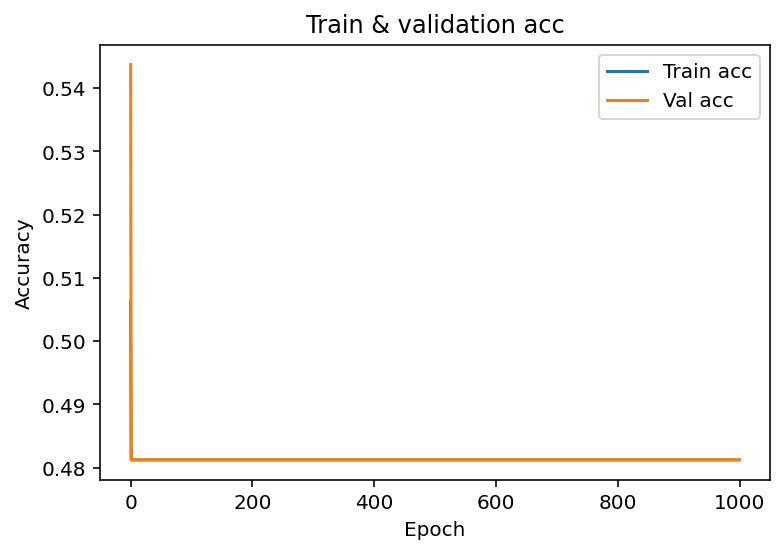

In [ ]:
# Train a logistic regression classifier


trainer = LogisticRegressionTrainer(2,num_epochs = 1000 , lambd = .01)
trainer.train(x_train,y_train,x_val,y_val)
 
print(f"Final train loss: {trainer.train_loss_history[-1]}")
print(f"Final validation loss: {trainer.val_loss_history[-1]}")
print(f"Final train acc: {trainer.train_acc_history[-1]}")
print(f"Final validation acc: {trainer.val_acc_history[-1]}")

plt.plot(np.arange(trainer.num_epochs), trainer.train_loss_history, label="Train loss")
plt.plot(np.arange(trainer.num_epochs), trainer.val_loss_history, label="Val loss")
plt.title("Train & validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(np.arange(trainer.num_epochs), trainer.train_acc_history, label="Train acc")
plt.plot(np.arange(trainer.num_epochs), trainer.val_acc_history, label="Val acc")
plt.title("Train & validation acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
trainer.theta

array([-4.51769167e-96, -6.85703674e-07])

## Plotting decision boundaries

My logistic regression weights: [-1.25167502e-13 -1.25167502e-13 -1.37109620e-06]


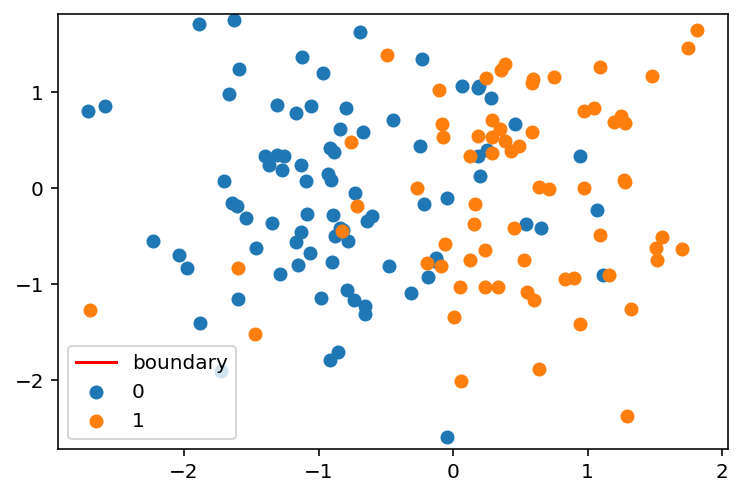

Sklearn logisitic regression weights: [-0.07231003  2.21807189  0.13182964]


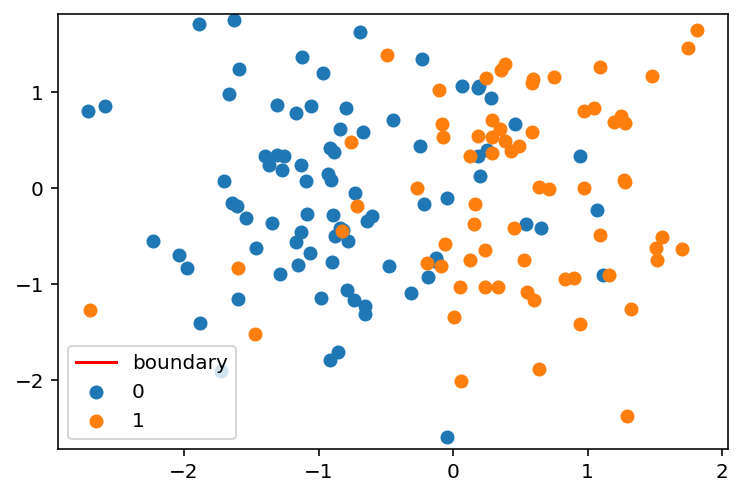

In [ ]:
# 0 = theta0 + theta1 * x + theta2 * y
# y = (-theta0 - theta1 * x) / theta2
print(f"My logistic regression weights: {trainer.theta}")
plot_decision_boundary(trainer.theta, x_val)
plot_data(x_val[:,1:], y_val)

model = LogisticRegression(penalty="l2", n_jobs=-1).fit(x_train[:,1:], y_train)
print(f"Sklearn logisitic regression weights: {np.append(model.intercept_, model.coef_)}")
plot_decision_boundary(np.append(model.intercept_, model.coef_), x_val)
plot_data(x_val[:,1:], y_val)

# Evaluation

In [ ]:
# Evaluate your model on the test set
trainer.evaluate(x_test,y_test)
print(f"Test loss: {trainer.test_loss}")
print(f"Test acc: {trainer.test_acc}")

Test loss: 0.6931471557636669
Test acc: 0.57
